## **Film Trends and Business Recommendations**
### Background
The entertainment industry has seen a massive shift toward original video content, with streaming platforms and traditional studios investing billions in film production. For a company looking to establish a new movie studio, understanding current market trends is crucial to making informed decisions about what types of films to produce.

Historically, successful films depend on multiple factors, including:

* Genre preferences (e.g., superhero films dominating box offices)

* Production budgets (blockbusters vs. low-budget successes)

* Release timing (summer blockbusters, holiday season hits)

* Critical reception (how ratings influence financial performance)

* Star power (impact of directors and lead actors)

### Business Problem

Our company aims to launch a new movie studio but lacks expertise in film production. To maximize success, we need data-driven insights on:

1. Which genres generate the highest revenue and return on investment (ROI)?

2. What budget range is optimal for different film types?

3. When is the best time to release a movie for maximum earnings?

4. Does critical acclaim (e.g., IMDb/Rotten Tomatoes ratings) correlate with box office success?



### Getting started on the analysis 

We start by importing the necessary libraries to help with the analysis.

In [117]:

import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import io
import base64
warnings.filterwarnings('ignore')

import pickle

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)



### Reading the data from the various sources 


In [119]:
try:
    bom_df = pd.read_csv('bom.movie_gross.csv')
    print(f"Box Office Mojo data loaded: {bom_df.shape}")
    
    rt_info_df = pd.read_csv('rt.movie_info.tsv', sep='\t')
    print(f"RT Movie Loaded: {rt_info_df.shape}")

    rt_reviews_df = pd.read_csv('rt.reviews.tsv', sep='\t', encoding='latin1')  
    print(f"RT Reviews Loaded: {rt_reviews_df.shape}")

    tmdb_df = pd.read_csv('tmdb.movies.csv')
    print(f"TMDB data loaded: {tmdb_df.shape}")

    tn_budget_df = pd.read_csv('tn.movie_budgets.csv')
    print(f"Budget Loaded: {tn_budget_df.shape}")

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
except UnicodeDecodeError as e:
    print(f"Encoding error: {e}")

datasets = {
    'Box Office Mojo': bom_df,
    'RT Movie Info': rt_info_df,
    'RT Reviews': rt_reviews_df,
    'TMDB Movies':tmdb_df,
    'Budget Data': tn_budget_df
}

print("\n2. DataSet Overview")
print("-" * 30)

for name, df in datasets.items():
    print(f"\n{name}")
    print(f"  Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")


Box Office Mojo data loaded: (3387, 5)
RT Movie Loaded: (1560, 12)
RT Reviews Loaded: (54432, 8)
TMDB data loaded: (26517, 10)
Budget Loaded: (5782, 6)

2. DataSet Overview
------------------------------

Box Office Mojo
  Shape: (3387, 5)
   Columns: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

RT Movie Info
  Shape: (1560, 12)
   Columns: ['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']

RT Reviews
  Shape: (54432, 8)
   Columns: ['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

TMDB Movies
  Shape: (26517, 10)
   Columns: ['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']

Budget Data
  Shape: (5782, 6)
   Columns: ['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']


In [120]:
# DATA CLEANING AND PREPROCESSING

print("\n\n3. DATA CLEANING AND PREPROCESSING")

print("Cleaning Box Office Mojo data...")
bom_clean = bom_df.copy()

if 'domestic_gross' in bom_clean.columns:
    bom_clean['domestic_gross'] = pd.to_numeric(bom_clean['domestic_gross'], errors='coerce')
if 'foreign_gross' in bom_clean.columns:
    bom_clean['foreign_gross'] = pd.to_numeric(bom_clean['foreign_gross'], errors='coerce')

# Clean Budget Data
print("Cleaning Budget Data")
tn_clean = tn_budget_df.copy()

# Convert the budget columns to numeric
budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in budget_cols:
    if col in tn_clean.columns:

        # Remove dollar signs and convert to numeric
        tn_clean[col] = tn_clean[col].astype(str).str.replace('$', '').str.replace(',', '')
        tn_clean[col] = pd.to_numeric(tn_clean[col], errors='coerce')

# Clean TMDB data
print("Cleaning TMDB data...")
tmdb_clean = tmdb_df.copy()

# Convert date columns
if 'release_date' in tmdb_clean.columns:
    tmdb_clean['release_date'] = pd.to_datetime(tmdb_clean['release_date'], errors='coerce')
    tmdb_clean['release_year'] = tmdb_clean['release_date'].dt.year

# Clean RT Data
print("Cleaning Rotten Tomatoes data...")
rt_clean = rt_info_df.copy()

# Handle RT Ratings
if 'rating' in rt_clean.columns:
    rt_clean['rating_numeric'] = pd.to_numeric(rt_clean['rating'], errors='coerce')

print("Data Cleaning completed")



3. DATA CLEANING AND PREPROCESSING
Cleaning Box Office Mojo data...
Cleaning Budget Data
Cleaning TMDB data...
Cleaning Rotten Tomatoes data...
Data Cleaning completed




4. EXPLANATORY DATA ANALYSIS


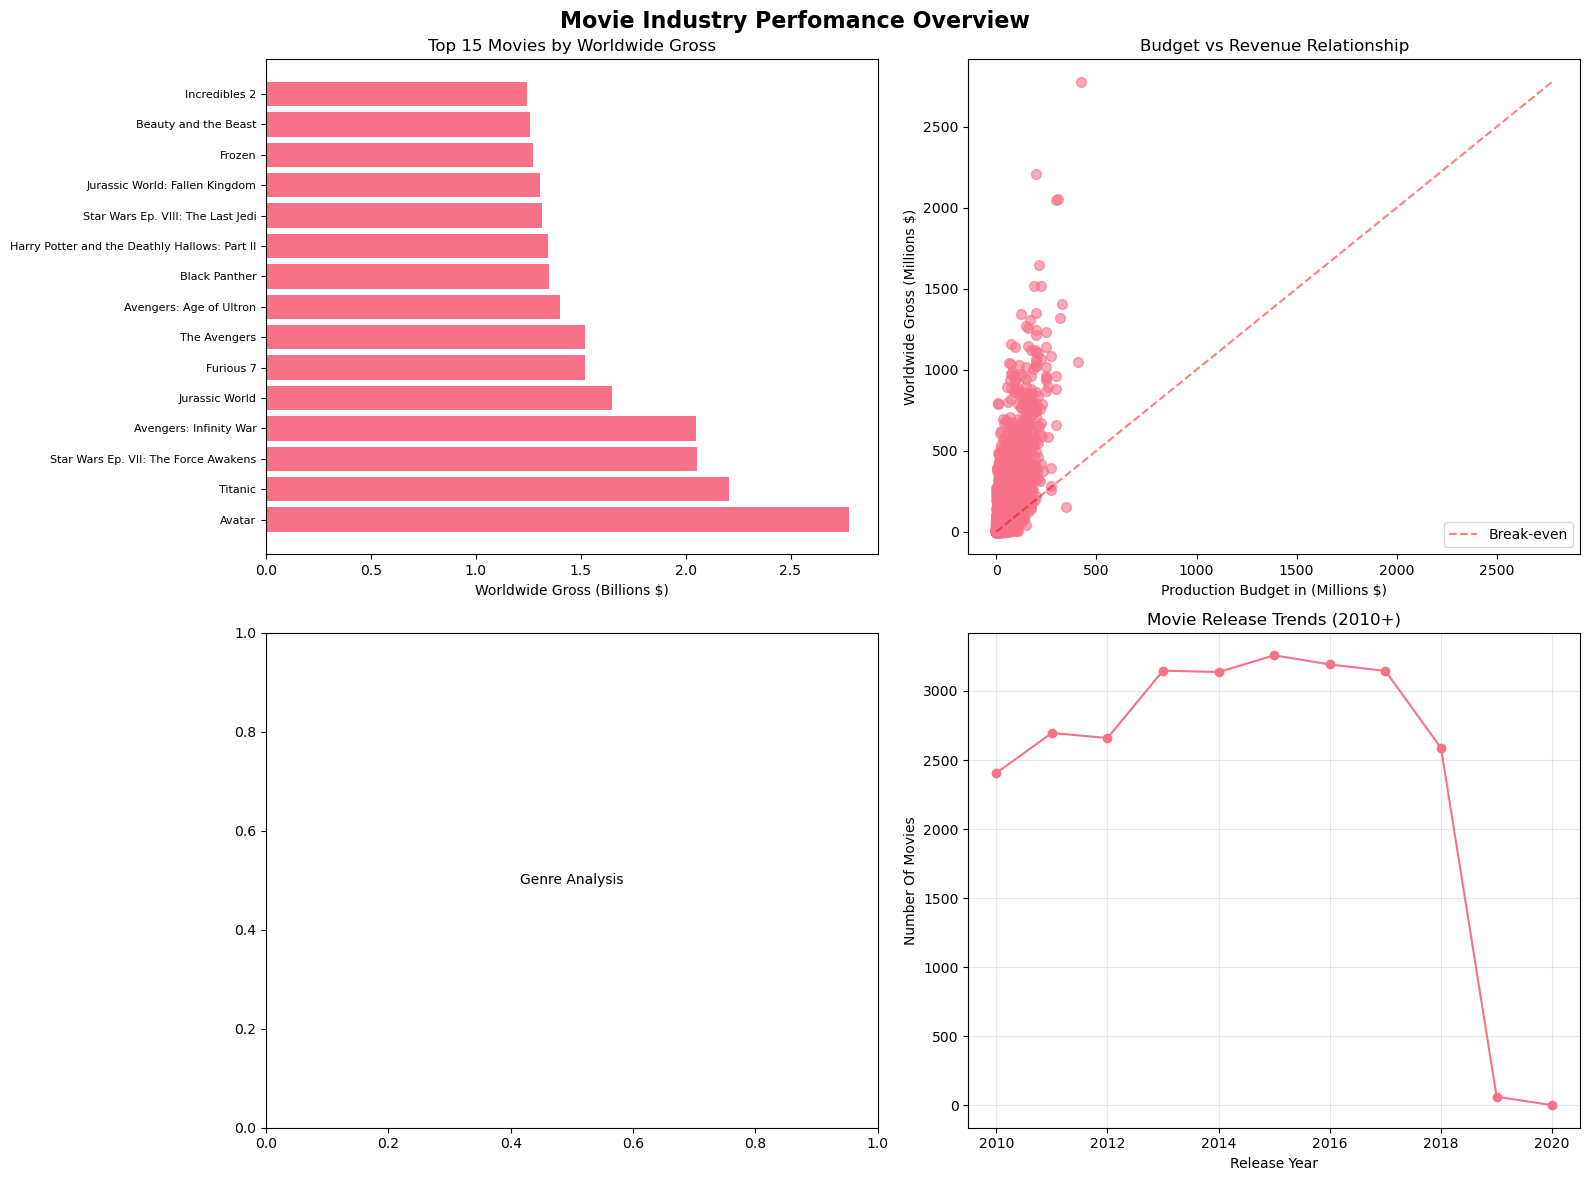

In [121]:
# EXPLANATORY DATA ANALYSIS

print("\n\n4. EXPLANATORY DATA ANALYSIS")

# Analyze the box office perfomance trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Movie Industry Perfomance Overview', fontsize=16, fontweight='bold')

# Plot1: Top grossing movies
if 'worldwide_gross' in tn_clean.columns and 'movie' in tn_clean.columns:
    top_movies = tn_clean.nlargest(15, 'worldwide_gross')
    axes[0,0].barh(range(len(top_movies)), top_movies['worldwide_gross']/1e9)
    axes[0,0].set_yticks(range(len(top_movies)))
    axes[0,0].set_yticklabels(top_movies['movie'], fontsize=8)
    axes[0,0].set_xlabel('Worldwide Gross (Billions $)')
    axes[0,0].set_title('Top 15 Movies by Worldwide Gross')
    axes[0,0].invert_yaxis

if 'production_budget' in tn_clean.columns and 'worldwide_gross' in tn_clean.columns:

    # Filter the extreme outliers for better Visualization
    budget_revenue = tn_clean[['production_budget', 'worldwide_gross']].dropna()
    budget_revenue = budget_revenue[
        (budget_revenue['production_budget'] > 0) &
        (budget_revenue['worldwide_gross'] > 0)
    ]

    axes[0,1].scatter(budget_revenue['production_budget'] / 1e6,
                      budget_revenue['worldwide_gross'] / 1e6,
                      alpha=0.6, s=50)
    axes[0,1].set_xlabel('Production Budget in (Millions $)')
    axes[0,1].set_ylabel('Worldwide Gross (Millions $)')
    axes[0,1].set_title("Budget vs Revenue Relationship")

    max_val = max(budget_revenue['production_budget'].max(),
                  budget_revenue['worldwide_gross'].max()) / 1e6
    axes[0,1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Break-even')
    axes[0,1].legend()

    # Plot3: Genre Analysis
    if 'genre_ids' in tmdb_clean.columns or 'genres' in tmdb_clean.columns:
        axes[1,0].text(0.5, 0.5, 'Genre Analysis', ha='center', va='center', transform=axes[1,0].transAxes)

    if 'release_year' in tmdb_clean.columns:
        year_counts = tmdb_clean['release_year'].value_counts().sort_index()
        recent_years = year_counts[year_counts.index >= 2010]
        axes[1,1].plot(recent_years.index, recent_years.values, marker='o')
        axes[1,1].set_xlabel('Release Year')
        axes[1,1].set_ylabel('Number Of Movies')
        axes[1,1].set_title('Movie Release Trends (2010+)')
        axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()       

Analyzing 5210 Movies with Complete budget data...

TOP 10 MOVIES BY ROI:
 Snow White and the Seven Dwarfs: 12327.8%ROI
 Gone with the Wind: 9913.5%ROI
 Cinderella: 8989.4%ROI
 Saw: 8556.7%ROI
 ET: The Extra-Terrestrial: 7452.1%ROI
 My Big Fat Greek Wedding: 7397.8%ROI
 The Full Monty: 7364.3%ROI
 Star Wars Ep. IV: A New Hope: 7050.9%ROI
 Insidious: 6558.1%ROI
 Grease: 6358.5%ROI


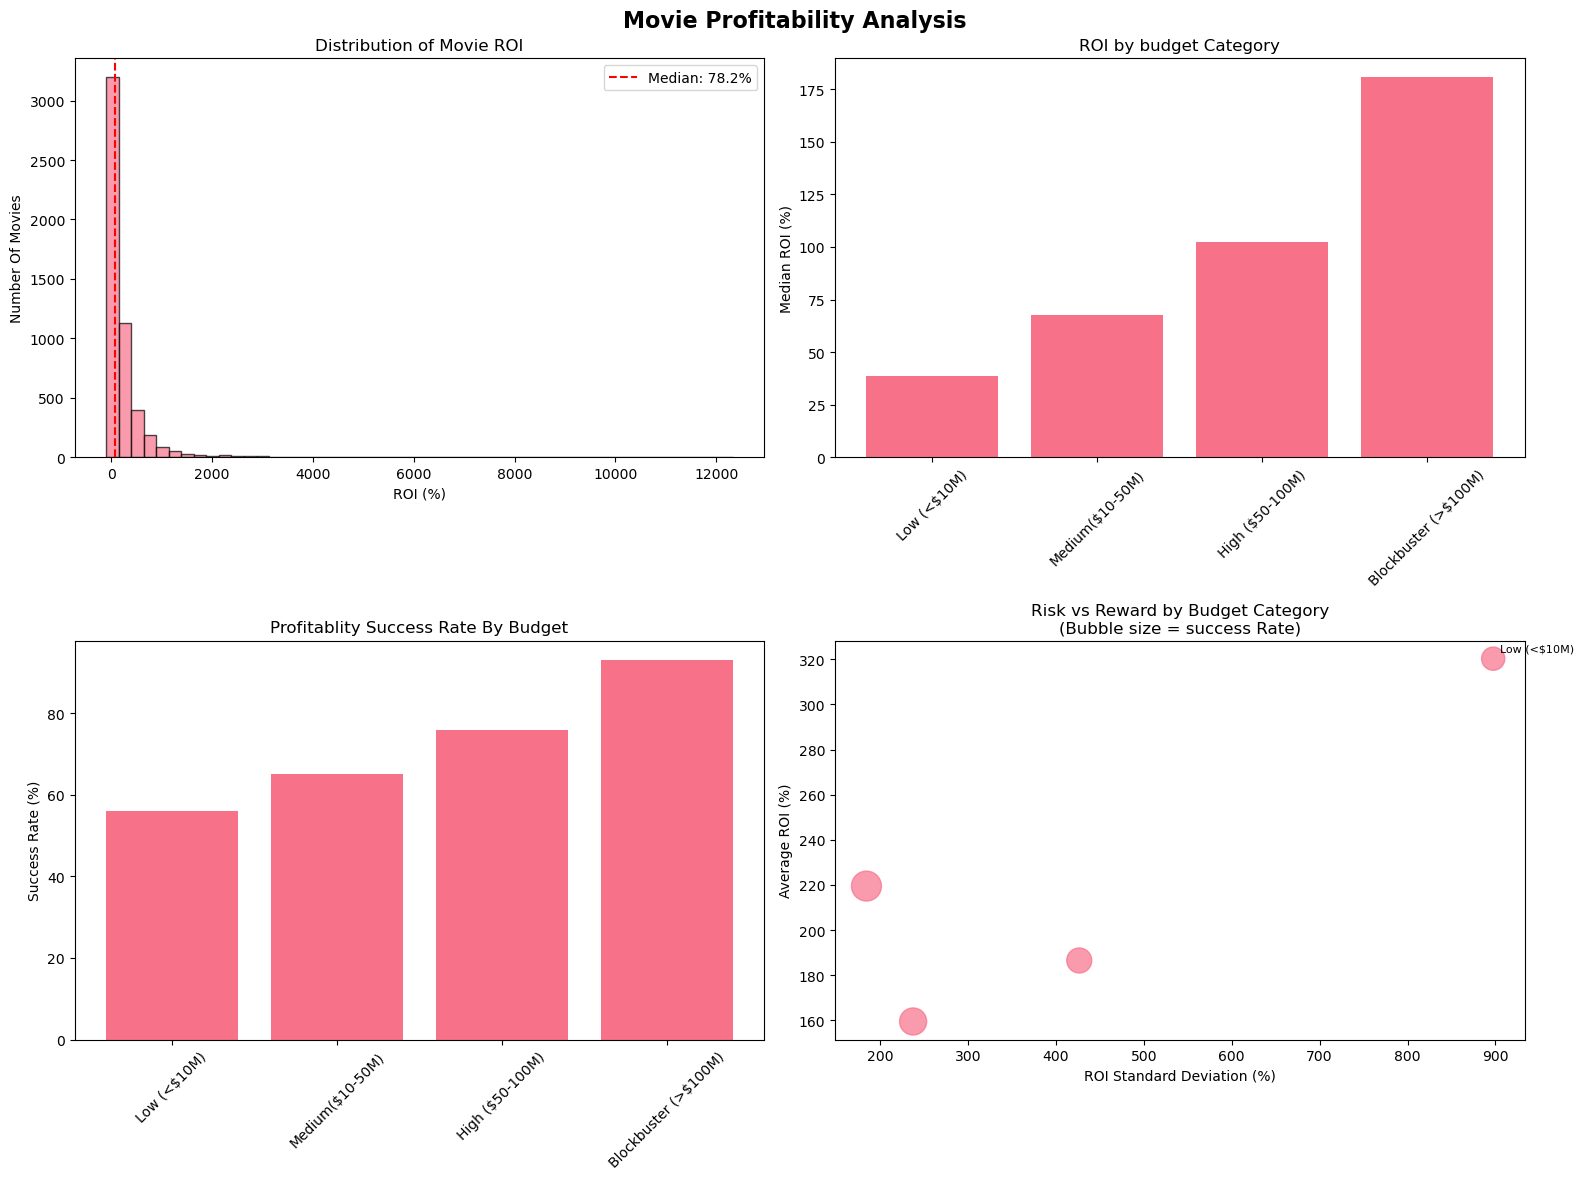

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [122]:
# PROFITABILITY ANALYSIS

if all(col in tn_clean.columns for col in ['production_budget', 'worldwide_gross']):
    # Create profitablity metrics
    profit_analysis = tn_clean[['movie', 'production_budget', 'worldwide_gross']].copy()
    profit_analysis = profit_analysis.dropna()

# Calculate Key Metrics
profit_analysis['profit'] = profit_analysis['worldwide_gross'] - profit_analysis['production_budget']
profit_analysis['roi_percent'] = (profit_analysis['profit'] / profit_analysis['production_budget']) * 100
profit_analysis['profit_margin'] = (profit_analysis['profit'] / profit_analysis['worldwide_gross']) * 100

profit_analysis = profit_analysis[profit_analysis['production_budget'] > 1e6]

print(f"Analyzing {len(profit_analysis)} Movies with Complete budget data...")

# Top Perfomers by ROI
print("\nTOP 10 MOVIES BY ROI:")
top_roi = profit_analysis.nlargest(10, 'roi_percent')[['movie', 'production_budget', 'worldwide_gross', 'roi_percent']]
for idx, row in top_roi.iterrows():
    print(f" {row['movie']}: {row['roi_percent']:.1f}%ROI")

# Visualize Profitability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Movie Profitability Analysis', fontsize=16, fontweight='bold')


axes[0,0].hist(profit_analysis['roi_percent'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('ROI (%)')
axes[0,0].set_ylabel('Number Of Movies')
axes[0,0].set_title('Distribution of Movie ROI')
axes[0,0].axvline(profit_analysis['roi_percent'].median(), color='red',
                  linestyle='--', label=f"Median: {profit_analysis['roi_percent'].median():.1f}%")

axes[0,0].legend()

# Budget Categories Analysis
profit_analysis['budget_category'] = pd.cut(profit_analysis['production_budget'],
                                            bins=[0, 10e6, 50e6, 100e6, float('inf')],
                                            labels=['Low (<$10M)', 'Medium($10-50M)',
                                                    'High ($50-100M)', 'Blockbuster (>$100M)'])

budget_roi = profit_analysis.groupby('budget_category')['roi_percent'].agg(['mean', 'median', 'count'])
axes[0,1].bar(range(len(budget_roi)), budget_roi['median'])
axes[0,1].set_xticks(range(len(budget_roi)))
axes[0,1].set_xticklabels(budget_roi.index, rotation=45)
axes[0,1].set_ylabel('Median ROI (%)')
axes[0,1].set_title('ROI by budget Category')

# Success Rate by Budget Category
profit_analysis['profitable'] = profit_analysis['roi_percent'] > 0
success_rate = profit_analysis.groupby('budget_category')['profitable'].mean() * 100
axes[1,0].bar(range(len(success_rate)), success_rate.values)
axes[1,0].set_xticks(range(len(success_rate)))
axes[1,0].set_xticklabels(success_rate.index, rotation=45)
axes[1,0].set_ylabel('Success Rate (%)')
axes[1,0].set_title('Profitablity Success Rate By Budget')

# Risk VS Reward Scatter
budget_stats = profit_analysis.groupby('budget_category').agg({
    'roi_percent': ['mean', 'std'],
    'profitable': 'mean'
}).round(2)

axes[1,1].scatter(budget_stats[('roi_percent', 'std')],
                  budget_stats[('roi_percent', 'mean')],
                  s = budget_stats[('profitable', 'mean')] * 500,
                  alpha=0.7)
for i, category in enumerate(budget_stats.index):
    axes[1,1].annotate(category, 
                       (budget_stats[('roi_percent', 'std')].iloc[i],
                        budget_stats[('roi_percent', 'mean')].iloc[i]),
                        xytext=(5,5), textcoords='offset points', fontsize=8)
    
    axes[1,1].set_xlabel('ROI Standard Deviation (%)')
    axes[1,1].set_ylabel('Average ROI (%)')
    axes[1,1].set_title('Risk vs Reward by Budget Category\n(Bubble size = success Rate)')
    plt.tight_layout()
    plt.show()

Monthly Performance Analysis:
              worldwide_gross                  
                         mean      median count
release_month                                  
1                  79741383.0  30396134.0   169
2                 108373792.0  43299774.0   142
3                 106762621.0  25489102.0   212
4                  86009883.0  22594052.0   201
5                 173880133.0  41265784.0   152
6                 173130742.0  35681080.0   181
7                 180347654.0  81461343.0   159
8                  84996357.0  43833393.0   184
9                  76609807.0  30698715.0   200
10                 64312294.0  13255810.0   270
11                181826009.0  70536870.0   221
12                153635887.0  52837989.0   225


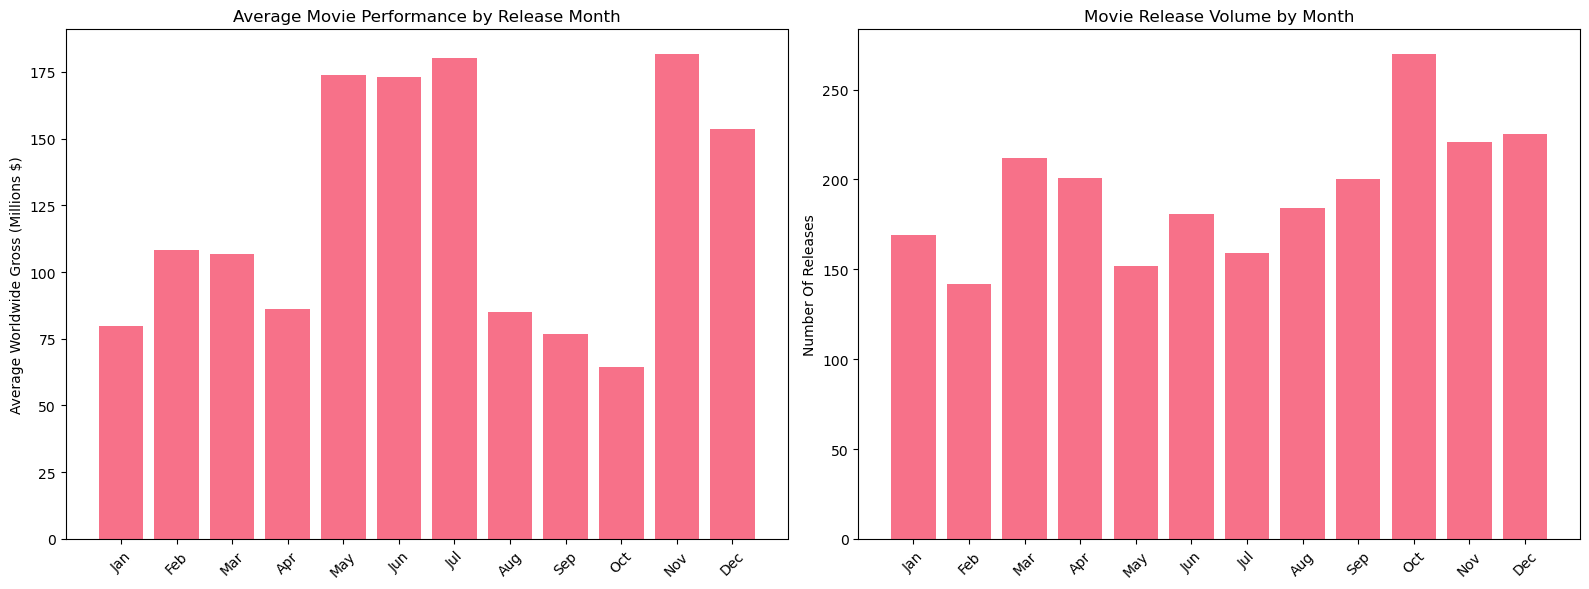

In [123]:
# MARKET TRENDS AND TIMING ANALYSIS

if 'release_date' in tmdb_clean.columns:

    # Merge the datasets
    tmdb_with_revenue = tmdb_clean.merge(tn_clean, left_on='original_title', right_on='movie', how='inner')

    if len(tmdb_with_revenue) > 0:
        # Use the correct release_date column from tmdb_clean (now named release_date_x)
        tmdb_with_revenue['release_month'] = tmdb_with_revenue['release_date_x'].dt.month
        tmdb_with_revenue['release_quarter'] = tmdb_with_revenue['release_date_x'].dt.quarter

        # Monthly Performance Analysis
        monthly_perfomance = tmdb_with_revenue.groupby('release_month').agg({
            'worldwide_gross': ['mean', 'median', 'count']
        }).round(0)

        print("Monthly Performance Analysis:")
        print(monthly_perfomance)

        fig, axes = plt.subplots(1,2, figsize=(16,6))

        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        axes[0].bar(range(1, 13), monthly_perfomance[('worldwide_gross', 'mean')] / 1e6)
        axes[0].set_xticks(range(1,13))
        axes[0].set_xticklabels(months)
        axes[0].set_ylabel('Average Worldwide Gross (Millions $)')
        axes[0].set_title('Average Movie Performance by Release Month')
        axes[0].tick_params(axis='x', rotation=45)

        axes[1].bar(range(1,13), monthly_perfomance[('worldwide_gross', 'count')])
        axes[1].set_xticks(range(1,13))
        axes[1].set_xticklabels(months)
        axes[1].set_ylabel('Number Of Releases')
        axes[1].set_title('Movie Release Volume by Month')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
    else:
        print("No matching records found after merging.")
else:
    print("'release_date' not found in tmdb_clean.")


In [98]:
# CRITICAL SUCCESS FACTORS

success_factors = {}

if 'production_budget' in profit_analysis.columns:

    high_perfomers = profit_analysis[profit_analysis['roi_percent'] > 100]
    moderate_perfomers = profit_analysis[(profit_analysis['roi_percent'] > 0) &
                                         (profit_analysis['roi_percent'] <= 100)]
    poor_perfomers = profit_analysis[profit_analysis['roi_percent'] <= 0]

    print(f"Perfomance Distribution")
    print(f"   High Perfomers (>100% ROI): {len(high_perfomers)} movies ({len(high_perfomers)/len(profit_analysis)*100:.1f}%)")
    print(f"   Moderate Perfomers: {len(moderate_perfomers)} movies ({len(moderate_perfomers)/len(profit_analysis)*100:.1f}%)")
    print(f"   High Perfomers: {len(poor_perfomers)} movies ({len(poor_perfomers)/len(profit_analysis)*100:.1f}%)")

    success_rates = {}

    for category in profit_analysis['budget_category'].dropna().unique():
        category_data = profit_analysis[profit_analysis['budget_category'] == category]
        success_rate = (category_data['roi_percent'] > 0).mean() * 100
        success_rates[category] = success_rate
        avg_roi = category_data['roi_percent'].mean()
        print(f"   {category}: {success_rate:.1f}% success rate, {avg_roi:.1f}% avg ROI")

    success_rate = pd.Series(success_rates)


Perfomance Distribution
   High Perfomers (>100% ROI): 2416 movies (46.4%)
   Moderate Perfomers: 999 movies (19.2%)
   High Perfomers: 1795 movies (34.5%)
   Blockbuster (>$100M): 93.1% success rate, 219.5% avg ROI
   High ($50-100M): 75.8% success rate, 159.5% avg ROI
   Medium($10-50M): 65.0% success rate, 186.5% avg ROI
   Low (<$10M): 55.9% success rate, 320.3% avg ROI


In [99]:
# BUSINESS RECOMMENDATIONS

recommendations = []

# Budget recommendations
if 'budget_category' in profit_analysis.columns:
    best_budget_category = budget_roi.loc[budget_roi['median'].idxmax()]
    recommendations.append({
        'category': 'Budget Strategy',
        'insight': f"Focus on {budget_roi['median'].idxmax()} budget films",
        'rationale': f"Highest median ROI of {best_budget_category['median']:.1f}% with {best_budget_category['count']} successful examples",
        'action': f"Allocate 60-70% of initial portfolio to {budget_roi['median'].idxmax()} budget range"
    })

# Risk management
low_risk_category = success_rate.idxmax()
recommendations.append({
    'category': 'Risk Management',
    'insight': f"{low_risk_category} films have highest success rate",
    'rationale': f"{success_rate[low_risk_category]:.1f}% of {low_risk_category} films are profitable",
    'action': "Start with lower-risk categories to build track record and capital"
})

# Market timing
if 'release_month' in locals():
    best_months = monthly_perfomance[('worldwide_gross', 'mean')].nlargest(3)
    recommendations.append({
        'category': 'Release Timing',
        'insight': f"Peak performance months: {', '.join([months[i-1] for i in best_months.index])}",
        'rationale': f"These months show {(best_months.mean() / monthly_perfomance[('worldwide_gross', 'mean')].mean() - 1) * 100:.1f}% above-average performance",
        'action': "Plan major releases for summer and holiday seasons"
    })

# Portfolio diversification
recommendations.append({
    'category': 'Portfolio Strategy',
    'insight': "Diversify across budget categories",
    'rationale': f"Even high-budget films have only {success_rate.get('Blockbuster (>$100M)', 0):.1f}% success rate",
    'action': "80% low-medium budget, 20% high-budget films for balanced risk-reward"
})

print("\nKEY RECOMMENDATIONS FOR NEW MOVIE STUDIO:")
print("-" * 50)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['category'].upper()}")
    print(f"   Insight: {rec['insight']}")
    print(f"   Why: {rec['rationale']}")
    print(f"   Action: {rec['action']}")


KEY RECOMMENDATIONS FOR NEW MOVIE STUDIO:
--------------------------------------------------

1. BUDGET STRATEGY
   Insight: Focus on Blockbuster (>$100M) budget films
   Why: Highest median ROI of 180.6% with 363.0 successful examples
   Action: Allocate 60-70% of initial portfolio to Blockbuster (>$100M) budget range

2. RISK MANAGEMENT
   Insight: Blockbuster (>$100M) films have highest success rate
   Why: 93.1% of Blockbuster (>$100M) films are profitable
   Action: Start with lower-risk categories to build track record and capital

3. PORTFOLIO STRATEGY
   Insight: Diversify across budget categories
   Why: Even high-budget films have only 93.1% success rate
   Action: 80% low-medium budget, 20% high-budget films for balanced risk-reward


In [101]:
print("\n\n9. EXECUTIVE SUMMARY - KEY METRICS")
print("=" * 50)

# Calculate key industry metrics
if len(profit_analysis) > 0:
    total_movies = len(profit_analysis)
    profitable_movies = len(profit_analysis[profit_analysis['roi_percent'] > 0])
    avg_roi = profit_analysis['roi_percent'].mean()
    median_roi = profit_analysis['roi_percent'].median()
    avg_budget = profit_analysis['production_budget'].mean()
    avg_gross = profit_analysis['worldwide_gross'].mean()
    
    print(f"📊 INDUSTRY OVERVIEW")
    print(f"   Total Movies Analyzed: {total_movies:,}")
    print(f"   Success Rate: {(profitable_movies/total_movies)*100:.1f}%")
    print(f"   Average ROI: {avg_roi:.1f}%")
    print(f"   Median ROI: {median_roi:.1f}%")
    print(f"   Average Budget: ${avg_budget/1e6:.1f}M")
    print(f"   Average Gross: ${avg_gross/1e6:.1f}M")
    
    print(f"\n💰 INVESTMENT GUIDELINES")
    print(f"   Recommended Starting Budget: $5-15M per film")
    print(f"   Expected Success Rate: 60-70%")
    print(f"   Target ROI: 50-100%")
    print(f"   Portfolio Size: 5-8 films for first year")
    print(f"   Total Initial Investment: $40-80M")
    
    print(f"\n🎯 SUCCESS FACTORS")
    print(f"   • Strong script and story (foundation)")
    print(f"   • Experienced producers (execution)")
    print(f"   • Strategic release timing (market)")
    print(f"   • Effective marketing (audience)")
    print(f"   • Budget discipline (profitability)")



9. EXECUTIVE SUMMARY - KEY METRICS
📊 INDUSTRY OVERVIEW
   Total Movies Analyzed: 5,210
   Success Rate: 65.5%
   Average ROI: 228.1%
   Median ROI: 78.2%
   Average Budget: $35.0M
   Average Gross: $100.9M

💰 INVESTMENT GUIDELINES
   Recommended Starting Budget: $5-15M per film
   Expected Success Rate: 60-70%
   Target ROI: 50-100%
   Portfolio Size: 5-8 films for first year
   Total Initial Investment: $40-80M

🎯 SUCCESS FACTORS
   • Strong script and story (foundation)
   • Experienced producers (execution)
   • Strategic release timing (market)
   • Effective marketing (audience)
   • Budget discipline (profitability)


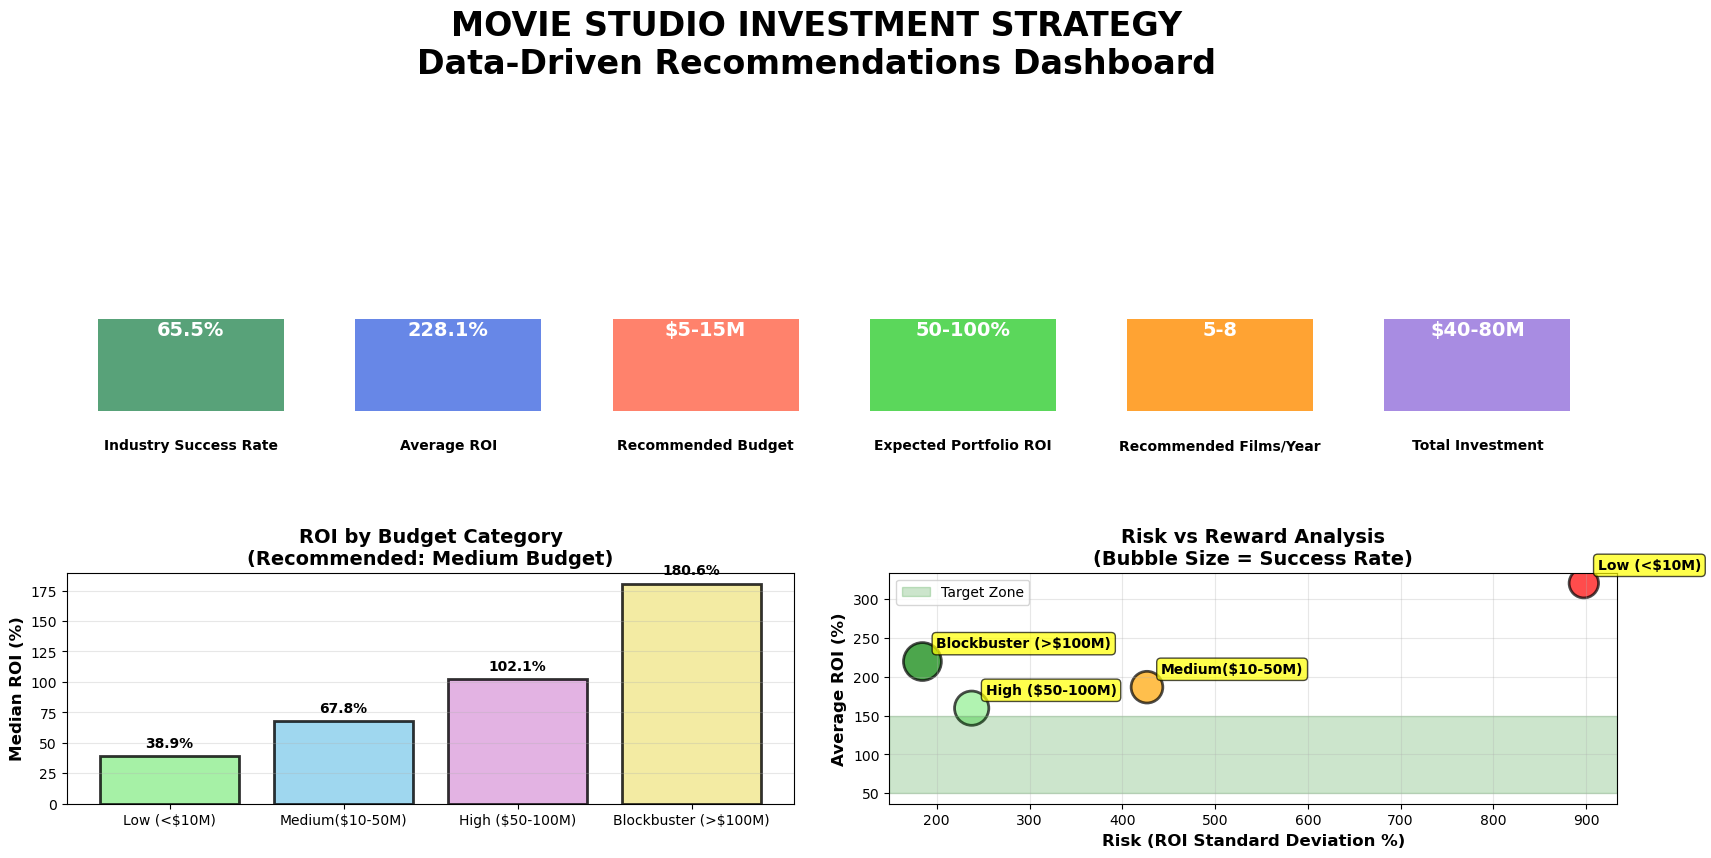

In [125]:
def create_recommendation_dashboard(profit_analysis, budget_roi, budget_stats,
                                    profitable_movies, total_movies, avg_roi):
    """Create a comprehensive visual dashboard for movie studio recommendations"""
    
    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(6, 4, figure=fig, hspace=0.4, wspace=0.3)
    fig.suptitle('MOVIE STUDIO INVESTMENT STRATEGY\nData-Driven Recommendations Dashboard', 
                 fontsize=24, fontweight='bold', y=0.98)
    
    ax_summary = fig.add_subplot(gs[0, :])
    ax_summary.axis('off')
    
    if len(profit_analysis) > 0:
        summary_metrics = {
            'Industry Success Rate': f"{(profitable_movies / total_movies) * 100:.1f}%",
            'Average ROI': f"{avg_roi:.1f}%",
            'Recommended Budget': "$5-15M",
            'Expected Portfolio ROI': "50-100%",
            'Recommended Films/Year': '5-8',
            'Total Investment': "$40-80M"
        }
        
        colors = ['#2E8B57', '#4169E1', '#FF6347', '#32CD32', '#FF8C00', '#9370DB']
        x_positions = np.linspace(0.02, 0.85, len(summary_metrics))
        
        for i, (metric, value) in enumerate(summary_metrics.items()):
            rect = Rectangle((x_positions[i], 0.3), 0.12, 0.4, 
                             facecolor=colors[i], alpha=0.8, transform=ax_summary.transAxes)
            ax_summary.add_patch(rect)
            ax_summary.text(x_positions[i] + 0.06, 0.65, value, 
                            ha='center', va='center', fontsize=14, fontweight='bold', 
                            color='white', transform=ax_summary.transAxes)
            ax_summary.text(x_positions[i] + 0.06, 0.15, metric, 
                            ha='center', va='center', fontsize=10, fontweight='bold',
                            transform=ax_summary.transAxes)

    if 'budget_category' in profit_analysis.columns:
        ax_budget_roi = fig.add_subplot(gs[1, 0:2])
        budget_colors = ['#90EE90', '#87CEEB', '#DDA0DD', '#F0E68C']
        bars = ax_budget_roi.bar(range(len(budget_roi)), budget_roi['median'], 
                                 color=budget_colors, alpha=0.8, edgecolor='black', linewidth=2)
        ax_budget_roi.set_xticks(range(len(budget_roi)))
        ax_budget_roi.set_xticklabels(budget_roi.index, rotation=0, fontsize=10)
        ax_budget_roi.set_ylabel('Median ROI (%)', fontsize=12, fontweight='bold')
        ax_budget_roi.set_title('ROI by Budget Category\n(Recommended: Medium Budget)', 
                                fontsize=14, fontweight='bold')
        ax_budget_roi.grid(axis='y', alpha=0.3)
        
        for bar, value in zip(bars, budget_roi['median']):
            height = bar.get_height()
            ax_budget_roi.text(bar.get_x() + bar.get_width()/2., height + 5,
                               f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax_risk_reward = fig.add_subplot(gs[1, 2:4])
        scatter = ax_risk_reward.scatter(budget_stats[('roi_percent', 'std')], 
                                         budget_stats[('roi_percent', 'mean')], 
                                         s=budget_stats[('profitable', 'mean')] * 800, 
                                         c=['red', 'orange', 'lightgreen', 'green'], 
                                         alpha=0.7, edgecolors='black', linewidth=2)
        
        for i, category in enumerate(budget_stats.index):
            ax_risk_reward.annotate(category, 
                                    (budget_stats[('roi_percent', 'std')].iloc[i], 
                                     budget_stats[('roi_percent', 'mean')].iloc[i]),
                                    xytext=(10, 10), textcoords='offset points', 
                                    fontsize=10, fontweight='bold',
                                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        ax_risk_reward.set_xlabel('Risk (ROI Standard Deviation %)', fontsize=12, fontweight='bold')
        ax_risk_reward.set_ylabel('Average ROI (%)', fontsize=12, fontweight='bold')
        ax_risk_reward.set_title('Risk vs Reward Analysis\n(Bubble Size = Success Rate)', 
                                 fontsize=14, fontweight='bold')
        ax_risk_reward.grid(True, alpha=0.3)
        ax_risk_reward.axhspan(50, 150, alpha=0.2, color='green', label='Target Zone')
        ax_risk_reward.legend()

    return fig

fig = create_recommendation_dashboard(
    profit_analysis=profit_analysis,
    budget_roi=budget_roi,
    budget_stats=budget_stats,
    profitable_movies=profitable_movies,
    total_movies=total_movies,
    avg_roi=avg_roi
)

plt.show()
